# AutoEncoder
ML에서 Manifold는 고차원 데이터가 존재하는 저차원 공간을 뜻하며,
데이터가 고차원 공간에 골고루 분포하는게 아닌 저차원 Manifold상에 존재한다는 
Manifold hypothesis가 딥러닝을 설명하는 중심 이론 중 하나로 사용된다.
이에 근거하여 적절히 작은 차원으로 mapping하여 representation을 찾는 것을
manifold learning이라고 하며, 이런 차원축소를 통해 차원의 저주를
극복하는 데 사용된다.

## Implementation
This implementation of Autoencoder is trained on FashionMNIST Dataset.

**Dimensions** 
- `b` : batch size
- `im` : flattened image size = 28*28 = 784
- `h` : latent vector size
### imports

In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import transforms

from tqdm import tqdm
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\PC\anaconda3\envs\diffuser\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Preperation (Dataset, DataLoader)

In [2]:
train_data = FashionMNIST('./Fashion/train_data', train=True, transform=transforms.ToTensor(), download=True)
test_data = FashionMNIST('./Fashion/test_data', train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

### Model
#### AutoEncoder
|input|<span style="font-weight:normal"> Flattened Image `(torch.tensor: (b, im))`</span>|
|:-------:|:---------------------------------------------------------------------------------|
|**output**| Reconstructed Flattened Image `(torch.tensor: (b, im))`|

`MNISTAutoencoder` is a AutoEncoder with latent dimension of 3.

In [9]:
class MNISTAutoencoder(nn.Module):
    def __init__(self):
        super(MNISTAutoencoder, self).__init__()
        lin_layer = lambda i, o: [
            nn.Linear(i, o),
            nn.BatchNorm1d(o),
            nn.ReLU(),
        ]
        
        self.encoder = nn.Sequential(
            *lin_layer(784, 500),
            *lin_layer(500, 500),
            *lin_layer(500, 500),
            *lin_layer(500, 300),
            nn.Linear(300, 3),
        )
        self.decoder = nn.Sequential(
            *lin_layer(3, 300),
            *lin_layer(300, 500),
            *lin_layer(500, 500),
            *lin_layer(500, 500),
            nn.Linear(500, 784),
            nn.BatchNorm1d(784),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### Declare model

In [10]:
model = MNISTAutoencoder().to(device)

### Training
#### Train setup

In [38]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss = nn.MSELoss().to(device)
epochs=5

#### Training loop

In [39]:
model.train()
losses = []
for epoch in range(epochs):
    ls = 0
    pbar = tqdm((torch.flatten(x, 1).to(device) for x, _ in train_loader), total=len(train_loader))
    for x in pbar:
        output = model(x)
        L = loss(output, x)

        optimizer.zero_grad()
        L.backward()
        optimizer.step()

        ls+=L.detach().cpu()
        pbar.set_description(f'epoch {epoch+1}: loss({L.detach()}) ')
    losses.append(ls/len(pbar))

epoch 5: loss(0.020338572561740875) : 100%|██████████| 469/469 [00:04<00:00, 107.20it/s]


#### Loss curve

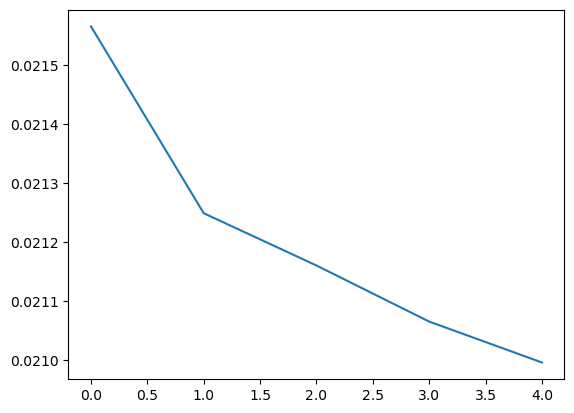

In [40]:
plt.plot(losses)

#### Plot Latent Distribution

100%|██████████| 79/79 [00:00<00:00, 127.76it/s]


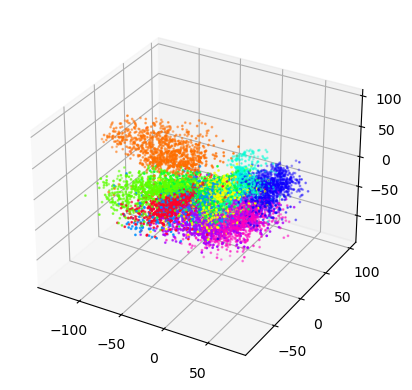

In [41]:
model.eval()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for x, t in tqdm(test_loader):
    output = model.encoder(torch.flatten(x, 1).to(device)).detach().cpu().T[:3]
    ax.scatter(*output, c=t, cmap="gist_rainbow", s=1)

#### Image Reconstruction

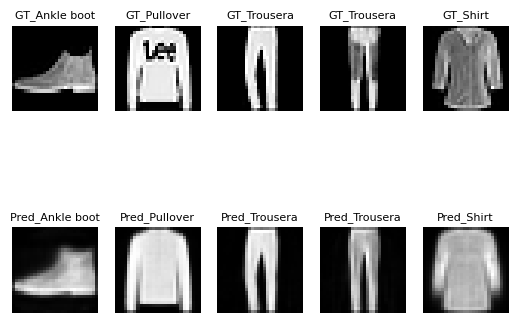

In [43]:
l = 5
class_names = ['T-shirt/top', 'Trousera', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
datas, t = (d[:l] for d in next(iter(test_loader)))

output = torch.flatten(datas, 1)
output = model(output.to(device)).cpu()

for i in range(l):
    plt.subplot(2, l, i+1), plt.axis('off')
    plt.imshow(datas[i][0], cmap='gray')
    plt.title('GT_'+class_names[t[i]], fontsize=8)

    plt.subplot(2, l, i+1+l), plt.axis('off')
    plt.imshow(output.detach()[i].view(28, 28), cmap='gray')
    plt.title('Pred_'+class_names[t[i]], fontsize=8)

#### Similar Image Search(knn)
##### Get latent vectors of train datas

In [44]:
def get_embeds(model, dataloader, device):
    return [[xx, h, tt] for x, t in tqdm(dataloader) for xx, h, tt in zip(x, model.encoder(torch.flatten(x, 1).to(device)).cpu().detach(),t)]

train_embed = get_embeds(model, DataLoader(train_data, batch_size=128), device)

100%|██████████| 469/469 [00:02<00:00, 163.12it/s]


##### Given test data find 5 nearest neighbor of train data

100%|██████████| 469/469 [00:00<00:00, 3245.22it/s]


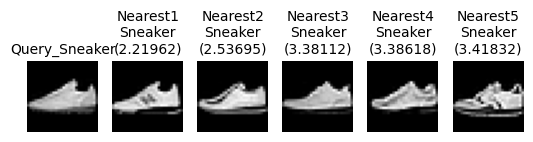

In [45]:
def find_knn(query, model, embed_datas, device, k=5):
    query = model.encoder(torch.flatten(query, 1).to(device))[0].cpu().detach()
    
    normlist = [i for _, x, _ in tqdm(DataLoader(embed_datas, batch_size=128)) for i in torch.norm(x-query, dim=1)]
    normlist = sorted(enumerate(normlist), key=lambda i: i[1])[:k]
    
    return [embed_datas[i]+[j] for i, j in normlist]

rows = 1
for n, (x, t) in enumerate(DataLoader(test_data, shuffle=True)):
    if n>=rows: break
    nearest5 = find_knn(x, model, train_embed, device)
    
    plt.subplot(rows, 6, 6*n+1), plt.axis('off')
    plt.imshow(x[0].view(28, 28, 1), cmap='gray')
    plt.title('Query_'+class_names[t[0]], fontsize=10)
    
    for i, (x, _, t, j) in enumerate(nearest5):
        plt.subplot(rows, 6, 6*n+i+2), plt.axis('off')
        plt.imshow(x.view(28, 28), cmap='gray')
        plt.title(f'Nearest{i+1}\n'+class_names[t]+f'\n({j:.5f})', fontsize=10)
    